# Demo of using PySINDy with Hydrogym output

See `examples/pysindy/run-natural.py` for the code used to generate the lift/drag coefficients.  In this case we used the "natural" flow (i.e. without actuation).  We could also force the flow and use SINDy+c to identify a low-dimensional model including the effect of the input.

This notebook follows the approach in ["Sparse reduced-order modeling: Sensor-based dynamics to full-state estimation"](https://arxiv.org/abs/1706.03531) where the authors use time-series measurements of the lift coefficient to identify a a cubic second-order model for the dynamics of the cylinder wake.  We'll also look at using SINDYc to identify a model of the controlled flow, and use this model to design a simple PID-type controller.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
import scipy.io as sio
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
mpl.rc("figure", figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

orange = "xkcd:red orange"
blue = "xkcd:ocean blue"

data_dir = "../examples/pysindy/output"

In [2]:
# Numerical differentiation for lift coefficient
diff = ps.SINDyDerivative(kind="finite_difference", k=2)

Before looking at a controlled system it often makes sense to try SINDy on the time series of the "natural" (i.e. zero control) case.  For the cylinder flow this is what was studied in the paper referenced above, although note that we use a slightly different definition of the state variables and variant of the SINDy algorithm so that the system isn't exactly identical to the one identified in that paper, although the two behave qualitatively similarly.

In [3]:
# Load the results of the transient simulation
data = np.loadtxt(f"{data_dir}/results.dat")

start_idx = 1000  # Truncate noise used to initialize transient sim
T0 = 5.6  # Post-transient vortex shedding period
t = data[start_idx:, 0]
CL, CD = data[start_idx:, 1], data[start_idx:, 2]

# Use numerical differentiation to estimate the first derivatives of lift
#   to be used as a secondary state variable
CL_dot = diff(CL, t)

luatex: /opt/anaconda3/lib/libtiff.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libpoppler.so.73)


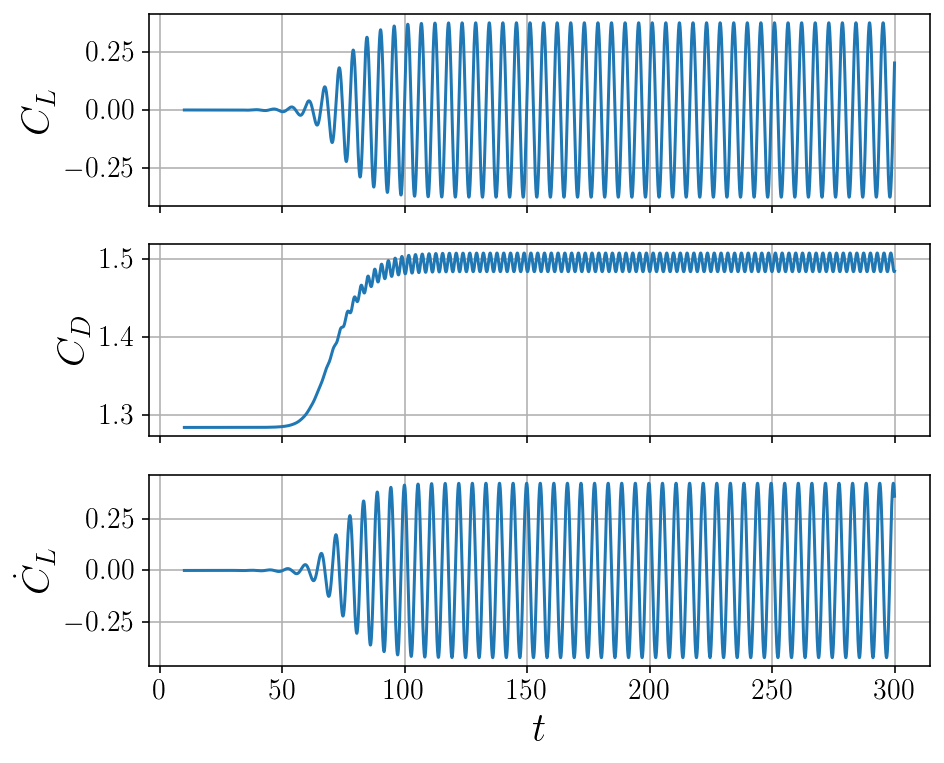

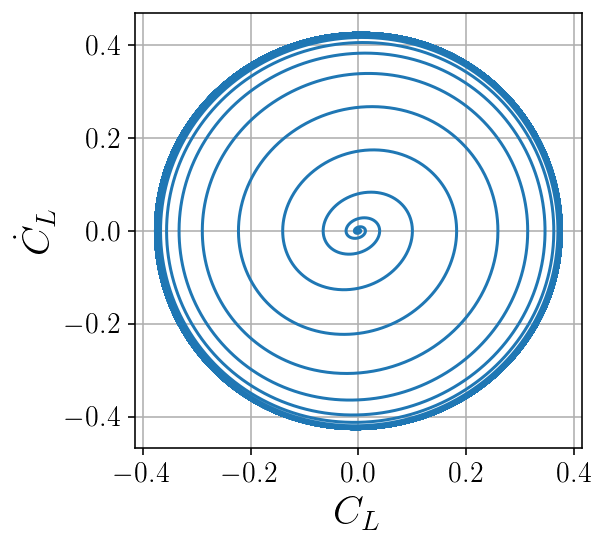

In [4]:
# Time series of lift and derivative
fig, axs = plt.subplots(3, 1, figsize=(7, 6), sharex="col")
axs[0].plot(t, CL)
axs[0].grid()
axs[0].set_ylabel(r"$C_L$")

axs[1].plot(t, CD)
axs[1].grid()
axs[1].set_ylabel(r"$C_D$")

axs[2].plot(t, CL_dot)
axs[2].grid()
axs[2].set_ylabel(r"$\dot{C}_L$")

axs[-1].set_xlabel(r"$t$")
plt.show()

# Phase portrait of (CL, CL_dot)
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

The dynamics of this flow are very well-studied, but in short what these plots show is that the unstable fixed point (where the simulation was initialized) is the minimum-drag state.  In addition, since this state is symmetric, it is zero-lift.  We can draw the physical insight from this that if we treat the lift coefficient and its derivative as state variables and seek to "stabilize" them we could by proxy minimize the drag.  This also tells us that the minimum drag is about $C_D = 1.265$, which is only about 15% lower than the typical post-transient value of $C_D \approx 1.49$.

With the data loaded and pre-processed we can use PySINDy to identify a low-dimensional model that predicts the evolution of the lift coefficient.  See the [PySINDy documentation](https://pysindy.readthedocs.io/en/latest/) for more detail on the use of the PySINDy package

In [5]:
X = np.stack((CL, CL_dot), axis=-1)  # First column is x, second is y

differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.1)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "dx"],
)
model.fit(X, t=t)
model.print()

(x)' = 1.000 dx
(dx)' = -1.149 x + 0.205 dx + -0.988 x^3 + -1.764 x^2 dx + -0.650 x dx^2 + -1.047 dx^3


In [6]:
# Evaluate the identified ODE
X_sim = model.simulate(X[0], t=t)

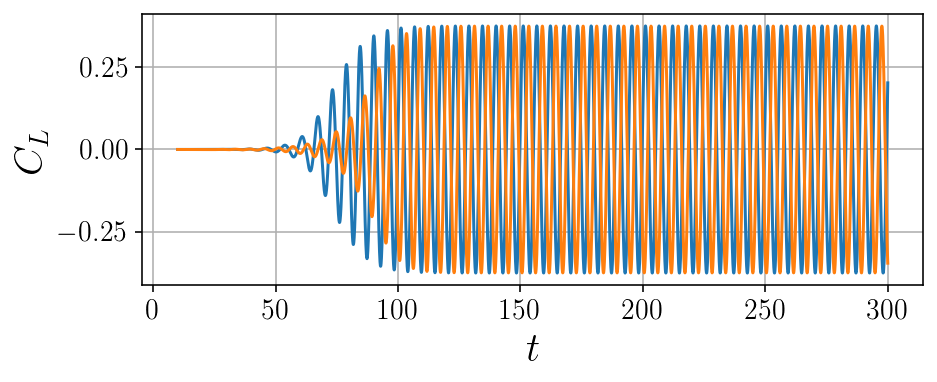

In [7]:
# Predicted time series of lift
plt.figure(figsize=(7, 2.5))
plt.plot(t, CL)
plt.plot(t, X_sim[:, 0])
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$C_L$")
plt.show()

Because of phase drift in the early transient stage the long-term forecast is inaccurate.  However, the low-dimensional model matches the phase portrait of the DNS almost perfectly, demonstrating that the estimates of the "flow field" governing the dynamical systems trajectories are good.

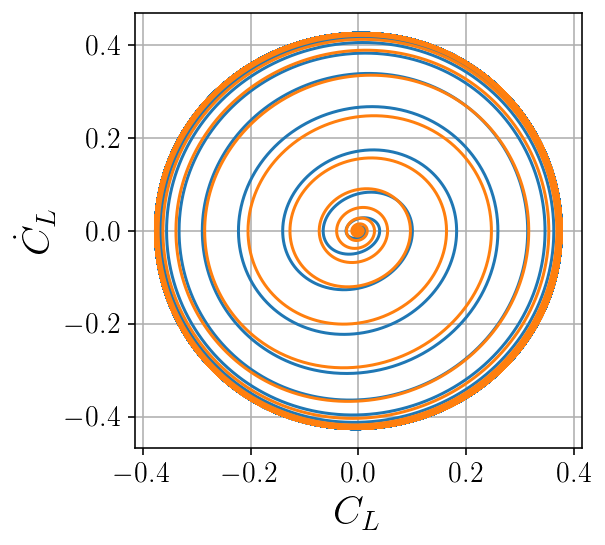

In [8]:
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.plot(X_sim[:, 0], X_sim[:, 1])
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

Let's pause for a second and take a closer look at the SINDy model.  This is a nonlinear oscillator with a quasilinear Van der Pol-like structure generating the unstable fixed point and oscillatory limit cycle.  The identified model _almost_ matches this structure:

$$
\begin{equation*}
\ddot{x} + \dot{x} \left( A^2 - \beta \right) + \kappa x \left( 1 + \alpha A^2 \right) = 0
\end{equation*}
$$
with the slowly-varying amplitude variable $A^2(x, \dot{x}) = k x^2 + \dot{x}^2 $ (analogous to the energy of a simple harmonic oscillator of unit mass).
With these definitions all variables are positive in this supercritical case.
Note that the numerical values will not _exactly_ match those in the SINDy model, but it is close enough that it can be used to motivate a feedback controller design.

The reason for writing it in this form will hopefully be clear soon, but before delving into the interpretation of this system, let's check that this actually makes sense.    First, If we write the SINDy model as

$$
\begin{align*}
\ddot{x} &= \xi_1 x + \xi_2 \dot{x} + \xi_3 x^3 + \xi_4 x^2 \dot{x} + \xi_5 x \dot{x}^2 + \xi_6 \dot{x}^3 \\
&= \xi_1 x\left(1 + (\xi_3 x^2 + \xi_5 \dot{x}^2) / \xi_1 \right) + \dot{x}\left(\xi_2 + \xi_4 x^2 + \xi_6 \dot{x}^2 \right)
\end{align*}
$$
then in order for the amplitude $A$ to appear in both terms of the oscillator model we would need $k \approx \xi_3/\xi_5 \approx \xi_4/\xi_6$.  We can easily check this:

In [9]:
coeffs = model.coefficients()[1, :]
c1, c2, c3, c4, c5, c6 = coeffs[np.nonzero(coeffs)[0]]

# Check that independent estimates of "stiffness"
omega0 = 2 * np.pi / T0
c3 / c5, c4 / c6, omega0**2

(1.520206664675226, 1.6846105805991085, 1.2588781123838466)

That approximation is good to within 10% or so, which is enough for this qualitative stage of the analysis.  Let's define $k$ as the average of the two estimators: $k = (\xi_4/\xi_6 + \xi_3/\xi_5^) / 2$.  Now we should check that this does define a more-or-less slowly-varying amplitude $A$

1.6024086226371672


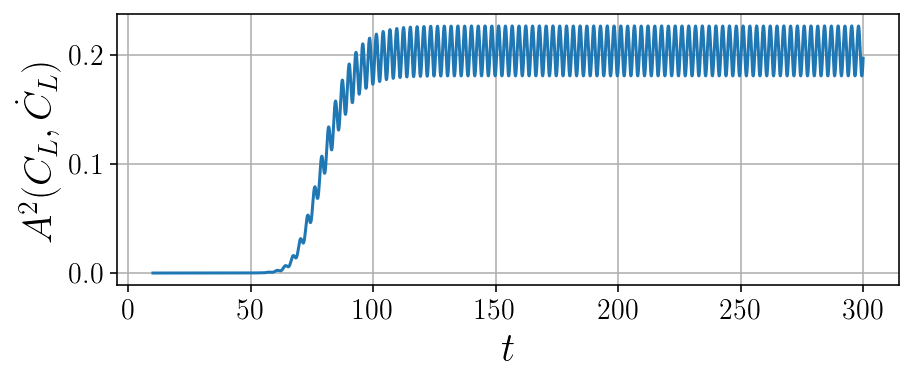

In [10]:
k = 0.5 * (c3 / c5 + c4 / c6)
# k = omega0 ** 2
print(k)
A_sq = k * CL**2 + CL_dot**2

# Predicted time series of lift
plt.figure(figsize=(7, 2.5))
plt.plot(t, A_sq)
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$A^2(C_L,  \dot{C}_L)$")
plt.show()

Again, this isn't perfect: to really be a "slowly-varying amplitude" we'd like to see it smoothly saturate without the limit-cycle oscillations.  But it's reasonably close.

Next notice that $\xi_3 \approx \xi_6 \approx -1$.  Then we can approximately rewrite the SINDy model as
$$
\begin{align*}
\ddot{x} &= \xi_1 x\left(1 + (\xi_5 / \xi_1) A^2 \right) + \dot{x} \left(\xi_2 - A^2 \right) \\
\end{align*}
$$

This now matches the quasilinear form above if we define $\kappa = -\xi_1$, $\alpha = \xi_5 / \xi_1$, and $\beta = \xi_2$.
This is essentially a second-order version of a Stuart-Landau equation.
To make the structure even clearer and interpret the different terms, we can write it in the standard oscillator form
$$
\begin{equation*}
\ddot{x} + \nu(A) \dot{x} + \omega^2(A) x = 0,
\end{equation*}
$$
where $\nu = (A^2 - \beta)$ and $\omega^2 = \kappa(1 + \alpha A^2)$.

Now these terms have the following interpretation

- $\nu(A)$: amplitude-dependent "damping".  This is negative for small values of the amplitude $A$, which destabilizes the fixed point.  For $A^2 > \beta$ the damping is positive, so the amplitude tends to shrink.  The damping vanishes at $A^2 = \beta$, which defines the amplitude of the stable limit cycle. 
- $\omega(A)$: amplitude-dependent frequency.  This reflects the fact that the instability frequency of the flow linearized about the unstable equilibrium is different from the post-transient vortex shedding frequency.

# SINDYc (SINDy + control)

In order to develop a feedback controller we need a model for the how the actuation enters the dynamics.  To do that "non-intrusively" we can simulate flow again but add low-amplitude noise (see `examples/pysindy/run-forced.py`).

Keep in mind that this will be a rough approximation for several reasons:

* There may be a lot happening in the flow that isn't resolved in the instantaneous measurements, so using these directly as state variables will probably miss some things.  In other words, we're assuming that we're measuring the full state directly ($y = h(x, u) = x$, while the "true" behavior is probably something more general like
$$
\dot{x} = f(x, u), \qquad y = h(x, u).
$$
* A related issue is that the actuation is a rotation of the cylinder, and the observations are the aerodynamic loads on the cylinder.  As a result, we would expect that there will be "feed-through" from the control to the measurement (i.e. $h=h(x, u)$ in the equation above, and not just $h=h(x)$).
* Another related issue is that even though the flow has "low-dimensional dynamics" relative to the size of the DNS state, there are many damped modes that can be excited by control and are often necessary for developing a robust controller.  Therefore this approach will lead to a very coarse approximation of the controlled flow.

In [59]:
# Load the results of the transient simulation
data = np.loadtxt(f"{data_dir}/results_forced.dat")

t = data[:, 0]
CL, CD, u = data[:, 1], data[:, 2], data[:, 3]

# Use numerical differentiation to estimate the first derivatives of lift
#   to be used as a secondary state variable
CL_dot = diff(CL, t)

Split up the time series into "training" data (which includes the transient) and a post-transient "test" set.  This isn't really important since we're not evaluating the quality of the fit directly, but it will help for a sanity check. 

In [72]:
X = np.stack((CL, CL_dot), axis=-1)  # First column is x, second is y

t0 = 0
t_split = 150
train_idx = np.nonzero((t > t0) * (t < t_split))[0]
test_idx = np.nonzero((t > t0) * (t >= t_split))[0]
X_train = X[train_idx, :]
u_train = u[train_idx][:, None]
t_train = t[train_idx]
X_test = X[test_idx, :]
u_test = u[test_idx][:, None]
t_test = t[test_idx]

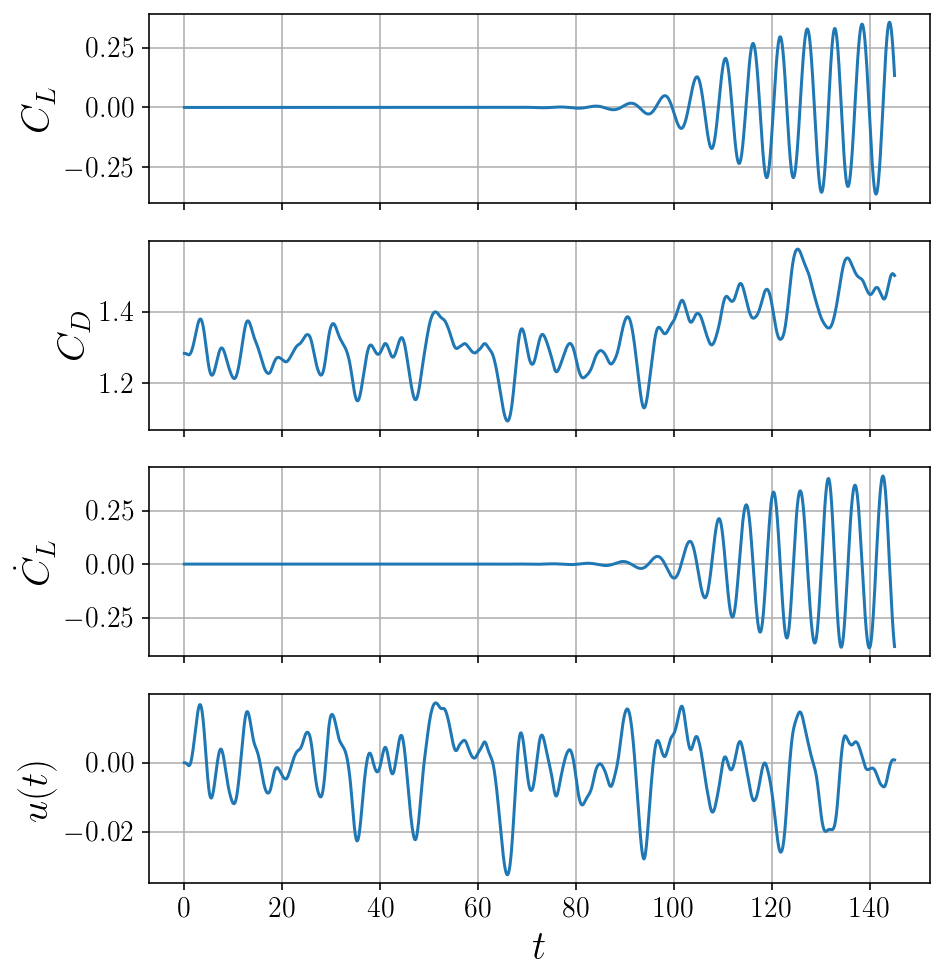

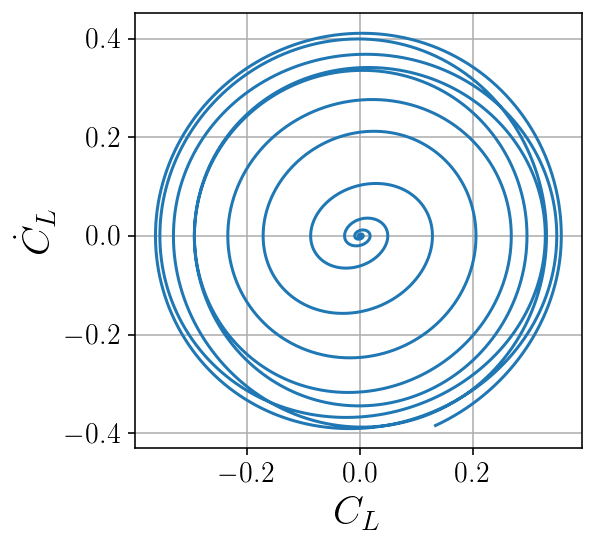

In [73]:
# Time series of lift and derivative
fig, axs = plt.subplots(4, 1, figsize=(7, 8), sharex="col")
axs[0].plot(t, CL)
axs[0].grid()
axs[0].set_ylabel(r"$C_L$")

axs[1].plot(t, CD)
axs[1].grid()
axs[1].set_ylabel(r"$C_D$")

axs[2].plot(t, CL_dot)
axs[2].grid()
axs[2].set_ylabel(r"$\dot{C}_L$")

axs[3].plot(t, u)
axs[3].grid()
axs[3].set_ylabel(r"$u(t)$")

axs[-1].set_xlabel(r"$t$")
plt.show()

# Phase portrait of (CL, CL_dot)
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

Now we repeat the SINDy model identification, but add in the control time series.

In [78]:
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=4)
optimizer = ps.STLSQ(threshold=0.1)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
)
# model.fit(X_train, u=u_train, t=t_train)
model.fit(
    [X_train, -X_train], u=[u_train, -u_train], t=t_train, multiple_trajectories=True
)
model.print()

(x0)' = 1.003 x1
(x1)' = -1.121 x0 + 0.181 x1 + -0.004 u0 + -1.207 x0^3 + -1.456 x0^2 x1 + 20.694 x0^2 u0 + -0.994 x0 x1^2 + 17.055 x0 x1 u0 + -1.070 x1^3 + 2.636 x1^2 u0


Fortunately this is fairly close to the model SINDy found for the natural flow but with an additional linear right-hand side forcing term $bu$.  Now we can check it against the "test" data.

In [79]:
# Evaluate the identified ODE with interpolated input forcing
X_sim = model.simulate(X_test[0], t=t_test, u=interp1d(t_test, u_test[:, 0]))

IndexError: index 0 is out of bounds for axis 0 with size 0

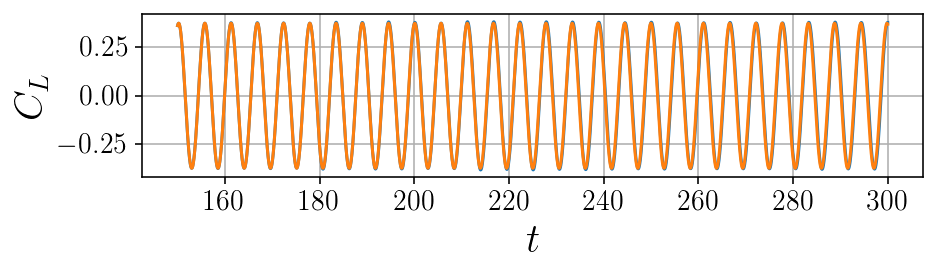

In [56]:
# Predicted time series of lift
plt.figure(figsize=(7, 1.5))
plt.plot(t_test, X_test[:, 0])
plt.plot(t_test, X_sim[:, 0])
plt.grid()
plt.xlabel(r"$t$")
plt.ylabel(r"$C_L$")
plt.show()

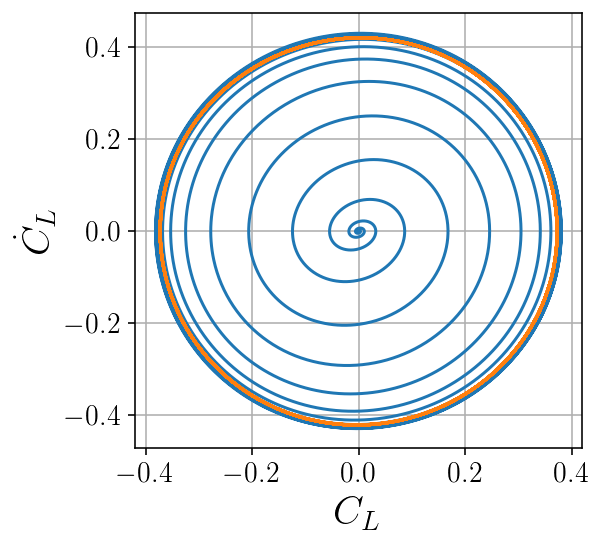

In [57]:
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.plot(X_sim[:, 0], X_sim[:, 1])
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

# Controller design

To design a simple feedback controller, let's start by taking another look at the quasilinear oscillator model:
$$
\begin{equation*}
\ddot{x} + \nu(A) \dot{x} + \omega^2(A) x = bu.
\end{equation*}
$$

First, consider a simpler case.
If $\nu$ and $\omega$ were constant, this would model a linear oscillator with total energy $E(t) = ( (\omega x)^2 + \dot{x}^2 ) / 2$.
The time derivative of the energy is
$$
\begin{align*}
\dot{E} &= (\omega^2 x + \ddot{x} ) \dot{x} \\ 
&= ( bu - \nu \dot{x} ) \dot{x}.
\end{align*}
$$

Without control, the energy dynamics are just $- \nu \dot{x}^2$.  In other words the energy of the oscillator decreases for positive damping and increases for negative damping $\nu < 0$.  If we define a derivative-type feedback control law $u = -k_d \nu \dot{x} / b$ for gain $k_d > 1$, the energy dynamics become
$$
\begin{equation*}
\dot{E} = -\nu (k_d - 1) \dot{x}^2,
\end{equation*}
$$
and (ideally) the system will converge to the origin.  For the nonlinear oscillator with state-dependent damping we could just replace $\nu$ in the control law by its maximum value $\beta$ at the origin:
$$
u = -\frac{k_d \beta}{b} \dot{x}.
$$

In [40]:
model.print()

(x0)' = 1.003 x1
(x1)' = -1.149 x0 + 0.200 x1 + 0.145 u0 + -0.951 x0^3 + -1.662 x0^2 x1 + -0.643 x0 x1^2 + -1.042 x1^3


In [41]:
coeffs = model.coefficients()[1, :]
c1, c2, b, c3, c4, c5, c6 = coeffs[np.nonzero(coeffs)[0]]

k = 0.5 * (c3 / c5 + c4 / c6)
beta = c2
alpha = c5 / c1

print(k, alpha, beta)

1.5362733541448785 0.5597828179729348 0.2001863087540298


In [42]:
# Check that "amplitude" coefficients are still comparable
np.sqrt(c3 / c5), np.sqrt(c4 / c6), omega0

(1.2158511782082013, 1.2626371690788631, 1.121997376282069)

Derivative coefficient: 2.07625139258595


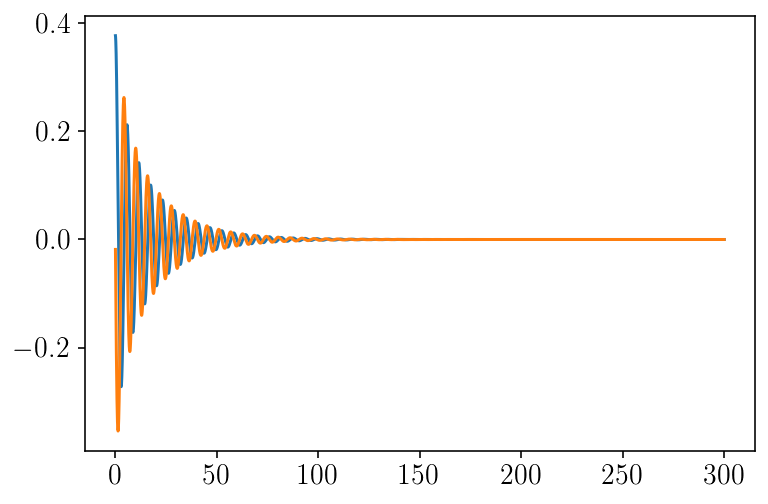

In [45]:
k_d = 1.5
print(f"Derivative coefficient: {k_d * beta / b}")


def ctrl(t, y):
    return -k_d * (beta / b) * y.flatten()[1]


def rhs(t, y):
    return model.predict(y[None, :], u=ctrl(t, y))


sol = solve_ivp(rhs, (t[0], t[-1]), X[-1], t_eval=t)

plt.plot(t, sol["y"].T)

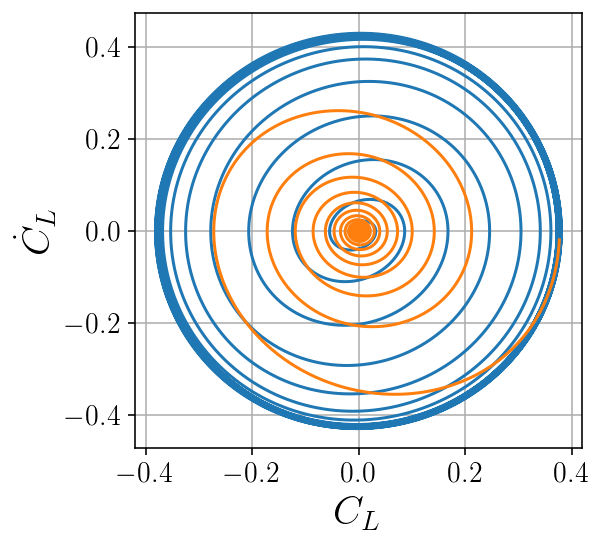

In [46]:
plt.figure(figsize=(4, 4))
plt.plot(CL, CL_dot)
plt.plot(sol["y"][0], sol["y"][1])
plt.grid()
plt.xlabel(r"$C_L$")
plt.ylabel(r"$\dot{C}_L$")
plt.show()

# DNS with controller

See `examples/pysindy/run-controlled.py` for the code used to run this model.

There are a few tricks necessary to get the derivative feedback to work.  For instance, because of the unmodeled feed-through effects the measurements are very sensitive to the control and can quickly become unstable.  An easy workaround is a simple causal low-pass filter, which we apply to both the state and derivative estimates.  A better approach might be a model-based extended Kalman filter.

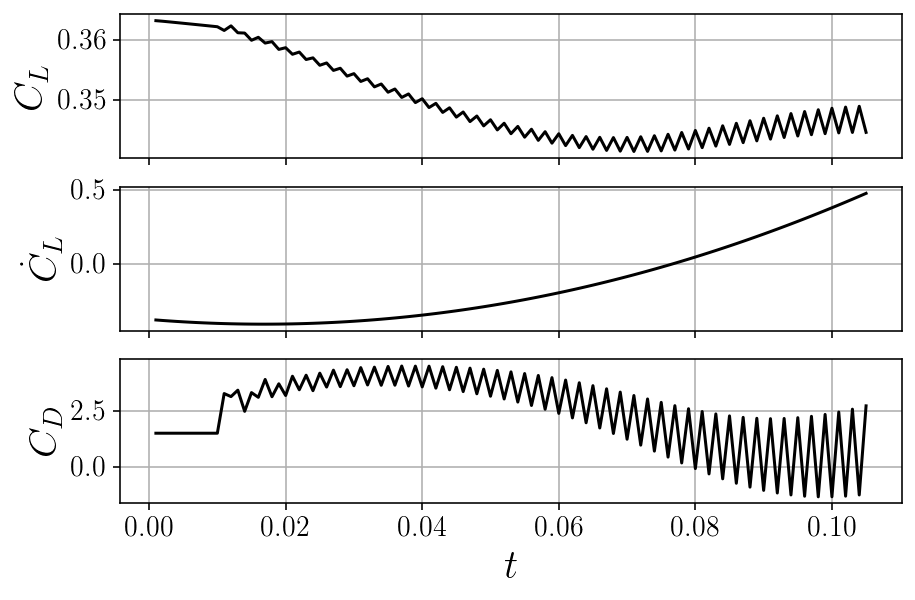

In [50]:
# Load the results of the transient simulation
data = np.loadtxt(f"{data_dir}/results_controlled.dat")

t = data[:, 0]
# t_start = 0.3  # Cutoff noisy transient for plots
t_start = 0.0  # Cutoff noisy transient for plots
t_idx = np.nonzero(t > t_start)[0]
t = t[t_idx]
dt = t[1] - t[0]
CL, CD, u = data[t_idx, 1], data[t_idx, 2], data[t_idx, 3]

# diff = ps.SINDyDerivative(kind="savitzky_golay", left=0.5, right=0.5, order=3)
diff = ps.SINDyDerivative(kind="savitzky_golay", left=1.0, right=1.0, order=3)
# diff = ps.SmoothedFiniteDifference()
CL_dot = diff(CL, t)

fig, ax = plt.subplots(3, 1, figsize=(7, 4.5), sharex="col")
ax[0].plot(t, CL, c="k")
ax[0].grid()
ax[0].set_ylabel(r"$C_L$")

ax[1].plot(t, CL_dot, c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\dot{C}_L$")

ax[2].plot(t, CD, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$C_D$")

ax[-1].set_xlabel(r"$t$")

plt.show()

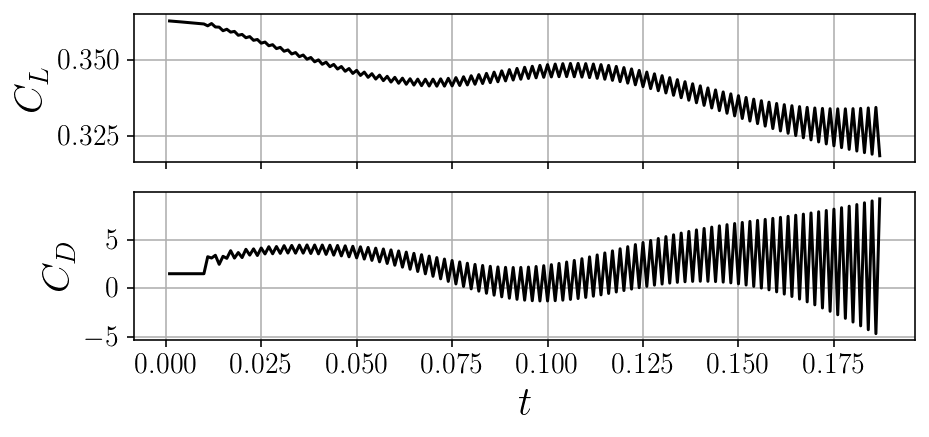

In [49]:
t_ctrl = 300

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex="col")

ax[0].plot(t[t < t_ctrl], CL[t < t_ctrl], c="k")
ax[0].plot(t[t >= t_ctrl], CL[t >= t_ctrl], c=orange)
ax[0].grid()
ax[0].set_ylabel(r"$C_L$")

ax[1].plot(t[t < t_ctrl], CD[t < t_ctrl], c="k")
ax[1].plot(t[t >= t_ctrl], CD[t >= t_ctrl], c=orange)
ax[1].grid()
ax[1].set_ylabel(r"$C_D$")

ax[-1].set_xlabel(r"$t$")

plt.show()

In [25]:
data = np.loadtxt(f"{data_dir}/results.dat")

start_idx = 1000  # Truncate noise used to initialize transient sim
t0 = data[start_idx:, 0]
CL0, CD0 = data[start_idx:, 1], data[start_idx:, 2]

# Use numerical differentiation to estimate the first derivatives of lift
#   to be used as a secondary state variable
CL0_dot = diff(CL0, t0)

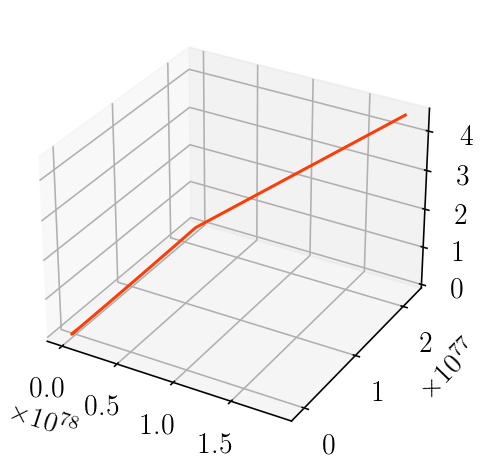

In [26]:
A = (omega0 * CL) ** 2 + CL_dot**2
A0 = (omega0 * CL0) ** 2 + CL0_dot**2

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
t_ctrl = 300
ax.plot(CL0, CL0_dot, A0, c="k")
ax.plot(CL, CL_dot, A, c=orange)
# ax.plot(CL[t<t_ctrl], CL_dot[t<t_ctrl], A[t<t_ctrl])
# ax.plot(CL[t>t_ctrl], CL_dot[t>t_ctrl], A[t>t_ctrl])

### Check the controller inputs

Filtered $C_L$, $\dot{C}_L$ estimates used for the feedback control

In [66]:
data = sio.loadmat(f"{data_dir}/pd-control.mat")

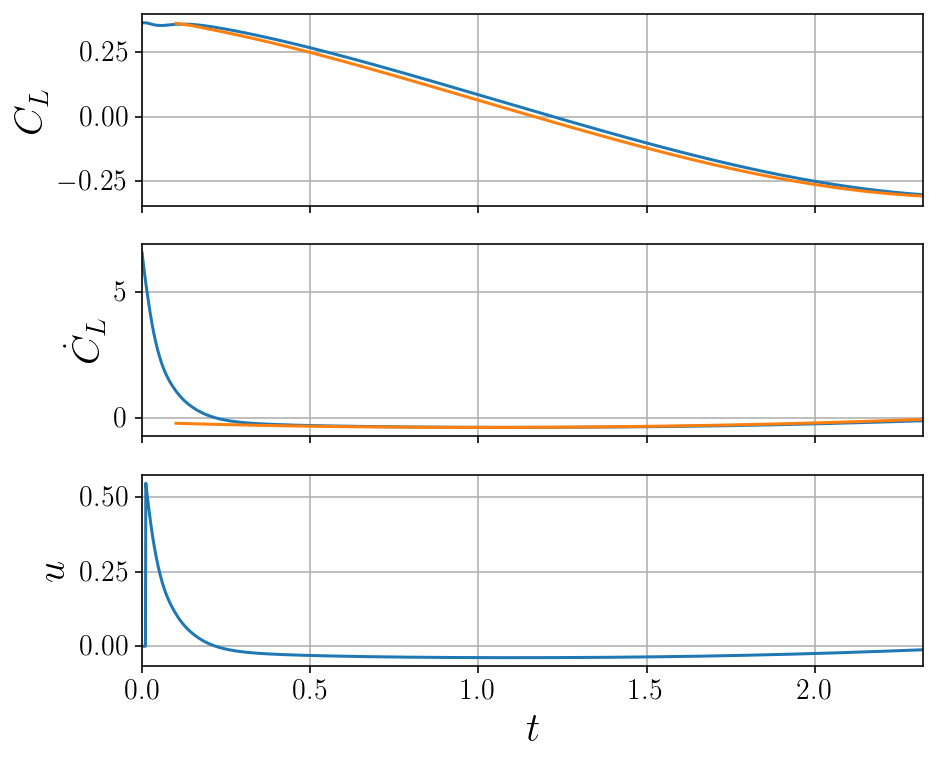

In [68]:
fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharex="col")

t_mat = (dt / 1) * np.arange(len(data["u"].flatten()))

ax[0].plot(t_mat, data["y"].flatten())
ax[0].plot(t, CL)
ax[0].grid()
ax[0].set_ylabel(r"$C_L$")

ax[1].plot(t_mat, data["dy"].flatten())
ax[1].plot(t, CL_dot)
ax[1].grid()
ax[1].set_ylabel(r"$\dot{C}_L$")

ax[2].plot(t_mat, data["u"].flatten())
ax[2].grid()
ax[2].set_ylabel(r"$u$")

ax[-1].set_xlabel(r"$t$")

ax[-1].set_xlim([0, t[-1]])

plt.show()